# A1: Data Curation

The goal of this assignment is to construct, analyze, and publish a dataset of monthly traffic on English Wikipedia from January 1 2008 through August 30 2021.

The purpose of the assignment is to demonstrate that you can follow best practices for open scientific research in designing and implementing your project, and make the project fully reproducible by others: from data collection to data analysis.

For this assignment, we combine data about Wikipedia page traffic from two different Wikimedia REST API endpoints into a single dataset, perform some simple data processing steps on the data, and then analyze that data.

In [1]:
import json
import requests
import datetime
import os

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import (FuncFormatter)

from pprint import pprint as pp

We define the various constants that are needed to access the API's

In [2]:
ENDPOINT_LEGACY = 'https://wikimedia.org/api/rest_v1/metrics/legacy/pagecounts/aggregate/{project}/{access-site}/{granularity}/{start}/{end}'
ENDPOINT_PAGEVIEWS = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/{project}/{access}/{agent}/{granularity}/{start}/{end}'

# Common Constants
PROJECT_DOMAIN = "en.wikipedia.org"
GRANULARITY_MONTHLY = 'monthly'

# Constants for Legacy
ACCESS_DESKTOP_LEGACY, ACCESS_MOBILE_LEGACY = "desktop-site", "mobile-site"
START_DATE_LEGACY = datetime.datetime(2007, 12, 1) # December 2007
END_DATE_LEGACY = datetime.datetime(2016, 8, 1) # July 2016 (we go to the end of next month)

# Constants for Pageviews
ACCESS_DESKTOP_PAGEVIEWS, ACCESS_MOBILE_APP_PAGEVIEWS, ACCESS_MOBILE_WEB_PAGEVIEWS = "desktop", "mobile-app", "mobile-web"
AGENT_PAGEVIEWS = 'user'
START_DATE_PAGEVIEWS = datetime.datetime(2015, 7, 1) # July 2015
END_DATE_PAGEVIEWS = datetime.datetime(2021, 10, 1) # September 2021 (we go to the end of next month)

In [3]:
RAW_DATA_PATH = '../data/raw'
PROCESSED_DATA_PATH = '../data/processed'
VISUALIZATIONS_DATA_PATH = '../data/visualizations'

PROCESSED_CSV_FILE_NAME = 'en-wikipedia_traffic_200712-202109.csv'
GRAPH_FILE_NAME = 'en-wikipedia_traffic_200712-202109.png'

## 1. Data Acquisition

In order to measure Wikipedia traffic from 2008-2021, you will need to collect data from two different API endpoints, the Legacy Pagecounts API and the Pageviews API.

* The Legacy Pagecounts API (documentation, endpoint) provides access to desktop and mobile traffic data from December 2007 through July 2016.
* The Pageviews API (documentation, endpoint) provides access to desktop, mobile web, and mobile app traffic data from July 2015 through last month.

For each API, we collect data for all months where data is available and then save the raw results into 5 separate JSON source data files.

The names of the files are as follows: `apiname_accesstype_firstmonth-lastmonth.json`

In [4]:
headers = {
    'User-Agent': 'https://github.com/sharma-apoorv',
    'From': 'sharmava@uw.edu'
}

We create the following functions to allow us to easily format the start and end dates for the 2 API calls to be made. 

In [5]:
def date_format_api(date):
    return date.strftime("%Y%m%d%H")

def date_format_filename(date):
    return date.strftime("%Y%m")

In [6]:
def api_call(endpoint, parameters):
    call = requests.get(endpoint.format(**parameters), headers=headers)
    response = call.json()
    
    return response

The following functions is the main functions that downloads the data by calling the 2 API's. The following is the outline of the steps for each API call:
1. For each *access route* that needs to be called:
2. Build the parameters dictionary
3. Call the API and download the data in JSON format
4. Download the JSON and store using the required format name 

In [7]:
def collect_data():
    
    # Collect Legacy Data
    for access in [ACCESS_DESKTOP_LEGACY, ACCESS_MOBILE_LEGACY]:
        
        # see: https://wikimedia.org/api/rest_v1/#!/Legacy_data/get_metrics_legacy_pagecounts_aggregate_project_access_site_granularity_start_end
        params_legacy = {
                            "project" : PROJECT_DOMAIN,
                            "access-site" : access,
                            "granularity" : GRANULARITY_MONTHLY,
                            "start" : date_format_api(START_DATE_LEGACY),
                            "end" : date_format_api(END_DATE_LEGACY)
                        }
        
        # call the API with the relevant parameters to get the information
        monthly_legacy = api_call(ENDPOINT_LEGACY, params_legacy)
        
        # save the raw datafile
        legacy_file_name = f'pagecounts_{access}_{date_format_filename(START_DATE_LEGACY)}-{date_format_filename(END_DATE_LEGACY)}.json'
        file_path = os.path.join(RAW_DATA_PATH, legacy_file_name) 
        with open(file_path, 'w') as f:
            json.dump(monthly_legacy, f)
        
    # Collect Pageviews Data
    for access in [ACCESS_DESKTOP_PAGEVIEWS, ACCESS_MOBILE_APP_PAGEVIEWS, ACCESS_MOBILE_WEB_PAGEVIEWS]:
        
        # see: https://wikimedia.org/api/rest_v1/#!/Pageviews_data/get_metrics_pageviews_aggregate_project_access_agent_granularity_start_end
        params_pageviews = {
                                "project" : PROJECT_DOMAIN,
                                "access" : access,
                                "agent" : AGENT_PAGEVIEWS,
                                "granularity" : GRANULARITY_MONTHLY,
                                "start" : date_format_api(START_DATE_PAGEVIEWS),
                                "end" : date_format_api(END_DATE_PAGEVIEWS)
                           }
        
        # call the API with the relevant parameters to get the information
        monthly_pageviews = api_call(ENDPOINT_PAGEVIEWS, params_pageviews)

        # save the raw datafile
        pageviews_file_name = f'pageviews_{access}_{date_format_filename(START_DATE_PAGEVIEWS)}-{date_format_filename(END_DATE_PAGEVIEWS)}.json'
        file_path = os.path.join(RAW_DATA_PATH, pageviews_file_name) 
        with open(file_path, 'w') as f:
            json.dump(monthly_pageviews, f)

In [8]:
collect_data()

## 2. Data Processing

We do the following processing for the JSON files downloaded:

* For data collected from the Pageviews API, we combine the monthly values for mobile-app and mobile-web to create a total mobile traffic count for each month.
* For all data, separate the value of timestamp into four-digit year (YYYY) and two-digit month (MM) and discard values for day and hour (DDHH).
* Convert from a long to wide format, with the following column names:
    * `year`
    * `month`
    * `pagecount_all_views`
    * `pagecount_desktop_views`
    * `pagecount_mobile_views` 
    * `pageview_all_views`
    * `pageview_desktop_views`
    * `pageview_mobile_views`


In [9]:
raw_files_paths = os.listdir(RAW_DATA_PATH)

Read in each file processed and convert this into a pandas dataframe. This can then be concatnated into a 
single data frame

In [10]:
df_list = []
for raw_files_path in raw_files_paths:
    with open(os.path.join(RAW_DATA_PATH, raw_files_path), 'r') as f:
      data = json.load(f)
    
    df = pd.json_normalize(data, record_path =['items'])
    df['Source'] = '_'.join(raw_files_path.split('_')[:2])
    
    df_list.append(df)

# Concat the data into a single df
df = pd.concat(df_list)

We can now remove the unnecessary column and pivot the table to convert into a wide format

In [11]:
df['views'] = df['views'].combine_first(df['count'])
df.drop(columns=['project', 'granularity', 'count', 'access-site', 'access', 'agent'], inplace=True)
df = pd.pivot_table(df, values='views', columns='Source', index=['timestamp']).reset_index()

In [12]:
df

Source,timestamp,pagecounts_desktop-site,pagecounts_mobile-site,pageviews_desktop,pageviews_mobile-app,pageviews_mobile-web
0,2007120100,2.998332e+09,NaN,NaN,NaN,NaN
1,2008010100,4.930903e+09,NaN,NaN,NaN,NaN
2,2008020100,4.818394e+09,NaN,NaN,NaN,NaN
3,2008030100,4.955406e+09,NaN,NaN,NaN,NaN
4,2008040100,5.159162e+09,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
161,2021050100,NaN,NaN,2.824416e+09,166485079.0,4.810094e+09
162,2021060100,NaN,NaN,2.505971e+09,150704624.0,4.433806e+09
163,2021070100,NaN,NaN,2.765584e+09,161461155.0,4.617448e+09
164,2021080100,NaN,NaN,2.763414e+09,161381193.0,4.570813e+09


We can now add in the relevant columns that are required, mentioned previously

In [13]:
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y%m%d%H')

df['year'] = df['timestamp'].dt.year
df['month'] = df['timestamp'].dt.month

# Fix: We need to use fillna to ensure that we are adding 2 numbers instead of NA values
df.fillna({'pagecounts_desktop-site':0, 
           'pagecounts_mobile-site':0,
           'pageviews_desktop':0,
           'pageviews_mobile-app':0,
           'pageviews_mobile-web':0}, inplace=True)

df['pageview_mobile_views'] = df['pageviews_mobile-app'].fillna(0) + df['pageviews_mobile-web'].fillna(0)
df['pageview_all_views'] = df['pageview_mobile_views'].fillna(0) + df['pageviews_desktop'].fillna(0)

df['pagecount_all_views'] = df['pagecounts_desktop-site'].fillna(0) + df['pagecounts_mobile-site'].fillna(0)

df.rename(columns={'pagecounts_desktop-site': 'pagecount_desktop_views', 
                   'pagecounts_mobile-site': 'pagecount_mobile_views',
                    'pageviews_desktop': 'pageview_desktop_views'}, inplace=True)
df = df[['year', 'month', 'pagecount_all_views', 'pagecount_desktop_views', 'pagecount_mobile_views', 'pageview_all_views', 'pageview_desktop_views', 'pageview_mobile_views']]

In [14]:
df

Source,year,month,pagecount_all_views,pagecount_desktop_views,pagecount_mobile_views,pageview_all_views,pageview_desktop_views,pageview_mobile_views
0,2007,12,2.998332e+09,2.998332e+09,0.0,0.000000e+00,0.000000e+00,0.000000e+00
1,2008,1,4.930903e+09,4.930903e+09,0.0,0.000000e+00,0.000000e+00,0.000000e+00
2,2008,2,4.818394e+09,4.818394e+09,0.0,0.000000e+00,0.000000e+00,0.000000e+00
3,2008,3,4.955406e+09,4.955406e+09,0.0,0.000000e+00,0.000000e+00,0.000000e+00
4,2008,4,5.159162e+09,5.159162e+09,0.0,0.000000e+00,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...,...,...
161,2021,5,0.000000e+00,0.000000e+00,0.0,7.800996e+09,2.824416e+09,4.976580e+09
162,2021,6,0.000000e+00,0.000000e+00,0.0,7.090482e+09,2.505971e+09,4.584510e+09
163,2021,7,0.000000e+00,0.000000e+00,0.0,7.544494e+09,2.765584e+09,4.778909e+09
164,2021,8,0.000000e+00,0.000000e+00,0.0,7.495608e+09,2.763414e+09,4.732194e+09


Cache the output as a csv file

In [15]:
processed_file_path = os.path.join(PROCESSED_DATA_PATH, PROCESSED_CSV_FILE_NAME)
df.to_csv(processed_file_path, index=False)

## 3. Analysis

Here we will visualize the dataset as a time series graph. The  visualization will track three traffic metrics: mobile traffic, desktop traffic, and all traffic (mobile + desktop).

We format the chart so that it is clear when the new API was being used.

In [16]:
df = pd.read_csv(processed_file_path)
df.replace(0, np.nan, inplace=True) # We do so so that the library does not plot the zeros

dates_df = df['month'].map(str)+ '-' +df['year'].map(str)
dates=[datetime.datetime.strptime(d,'%m-%Y').date() for d in dates_df]

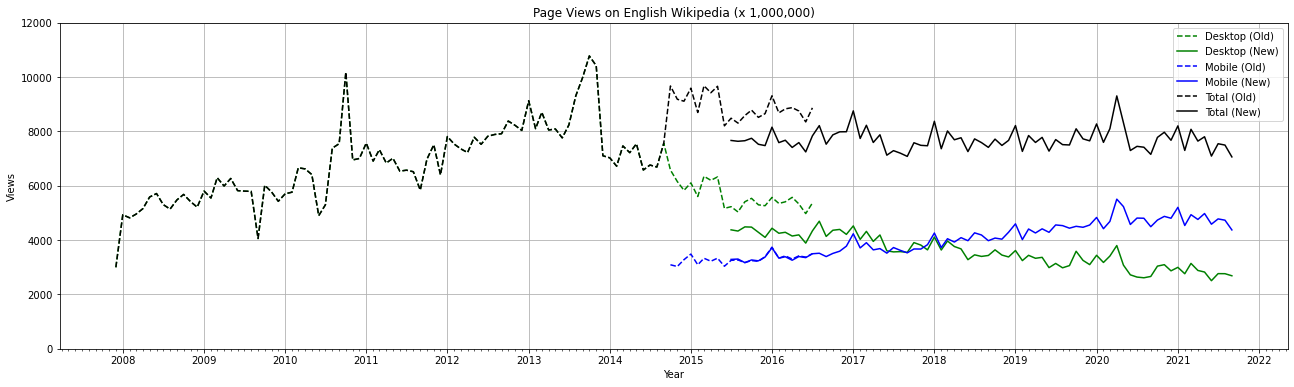

In [17]:
plt.figure(figsize=(22,6))
ax = plt.gca()

# Create lines and choose characteristics
plt.plot(dates, 'pagecount_desktop_views', 'g--', data=df, label='Desktop (Old)')
plt.plot(dates, 'pageview_desktop_views', 'g', data=df, label='Desktop (New)')

plt.plot(dates, 'pagecount_mobile_views', 'b--', data=df, label='Mobile (Old)')
plt.plot(dates, 'pageview_mobile_views', 'b', data=df, label='Mobile (New)')

plt.plot(dates, 'pagecount_all_views', 'k--', data=df, label='Total (Old)')
plt.plot(dates, 'pageview_all_views', 'k', data=df, label='Total (New)')

# # Add title and axis names
plt.title('Page Views on English Wikipedia (x 1,000,000)')
plt.xlabel('Year')
plt.ylabel('Views')

# format the x-ticks
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
yearsFmt = mdates.DateFormatter('%Y')

ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(yearsFmt)
ax.xaxis.set_minor_locator(months)

# format the y-ticks
scale_factor = 10**6
formatter = FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_factor))
ax.yaxis.set_major_formatter(formatter)
ax.set_ylim(ymin=0, ymax=12*10e8)

plt.legend()
plt.grid()

plt.savefig(os.path.join(VISUALIZATIONS_DATA_PATH, GRAPH_FILE_NAME))